<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_

<hr style="height:2px;border:none"/>

In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report

#Keras stuff
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD, rmsprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input

# Tensorflow GPU stuff :v
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


#Que se vea ancho el jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

Using TensorFlow backend.


In [2]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,stratify=y_train,random_state=42)

## a)
Visualice los datos que trabajaremos e intentaremos detectar en esta sección. ¿Qué dimensiones tienen las imágenes trabajadas? ¿Existen patrones similares entre los objetos de una misma clase? ¿Entre objetos de distintas clases?.

In [3]:
print(x_train.shape)

(45000, 32, 32, 3)


Las imágenes son de 32x32 pixeles, cada una con el canal RGB.

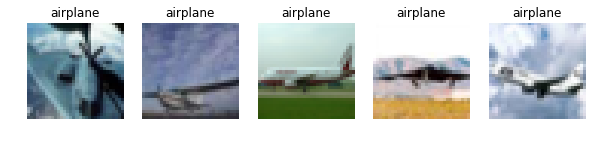

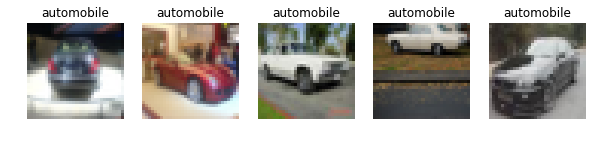

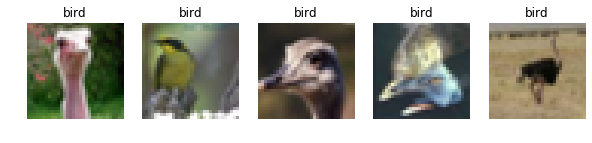

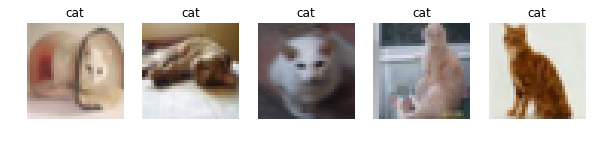

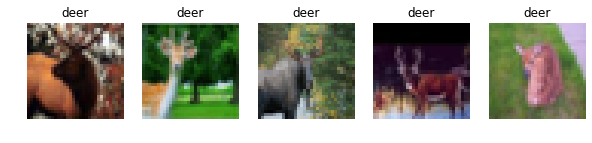

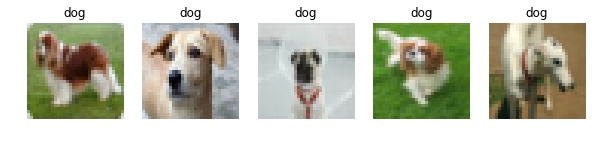

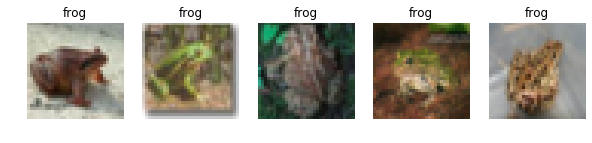

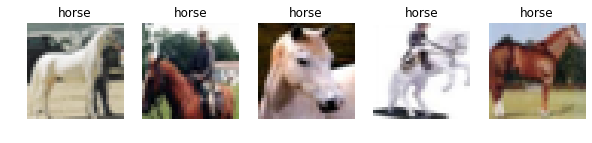

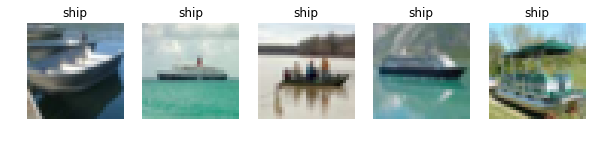

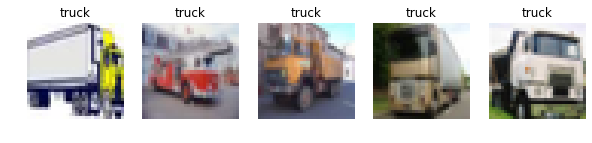

In [4]:
def chart_5_examples_of_class(class_number):
    idx_dato = [np.random.choice(np.where(y_train==class_number)[0]) for i in range(5)]
    f,axx = plt.subplots(1,5,figsize=(10,5))
    for i, dato in enumerate(idx_dato):
        axx[i%5].imshow(x_train[dato])
        axx[i%5].axis('off')
        axx[i%5].set_title(label_names[class_number])
    plt.show()
    
for i in range(10):
    chart_5_examples_of_class(i)

Se aprecia que en las imágenes están todos los objetos en general solos y a plean luz del día. Los objetos pueden estar en distintas perspectivas.

## b)
Prepare los subconjuntos de entrenamiento, validación y pruebas para ser entregados al modelo. Para ésto divida la intensidad original de pixel en cada canal por 255. Es importante notar que si desea trabajar con el orden de las dimensiones denominado ’th’ (por defecto para *Theano*) deberá realizar la transposición correspondiente para dejar el canal en donde corresponda. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

In [5]:
# x_train = x_train.transpose([0, 3, 1, 2]) #if 'th' dim-ordering is used
# x_test= x_test.transpose([0, 3, 1, 2]) 

import keras

y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)
Xnorm_train = x_train.astype('float32')/255
Xnorm_val = x_val.astype('float32')/255
Xnorm_test = x_test.astype('float32')/255

## c)
Defina una CNN simple con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 32 y 64 filtros de $3 \times 3$ y funciones de activación ReLU respectivamente. Para las capas de *pooling* utilice filtros de $2 \times 2$ con *stride* 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass* y el número de parámetros de cada capa.

In [6]:
def get_ann_b_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    return model

model = get_ann_b_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dens

## d) 
Entrene la CNN definida en **c)** utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^{-4}$ o inferior con una tasa de decaimiento, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema compare el entrenar con un optimizador adaptativo como es **RMSProp** con parámetros similares. Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.

In [7]:
model_d_sdg = get_ann_b_model()
model_d_rmsprop = get_ann_b_model()

model_d_sdg.compile(optimizer = SGD(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_d_sdg = model_d_sdg.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

Instructions for updating:
Use tf.cast instead.


In [8]:
model_d_rmsprop.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_d_rmsprop = model_d_rmsprop.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val, y_val))

In [9]:
def chart_metric(history,metric_name, epoch_number = 50):
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history[metric_name], '.-')
    plt.plot(epoch_arr, history.history['val_'+metric_name], '.-')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend( ('Train', 'Val') )
    
    if metric_name == 'acc':
        max_index = np.argmax(history.history['val_'+metric_name])
        max_value = history.history['val_'+metric_name][max_index].round(2)
        plt.annotate('Max = {}'.format(max_value), xy=(max_index+1, max_value), xycoords='data', xytext=(-100, -100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))

    plt.show()

SDG


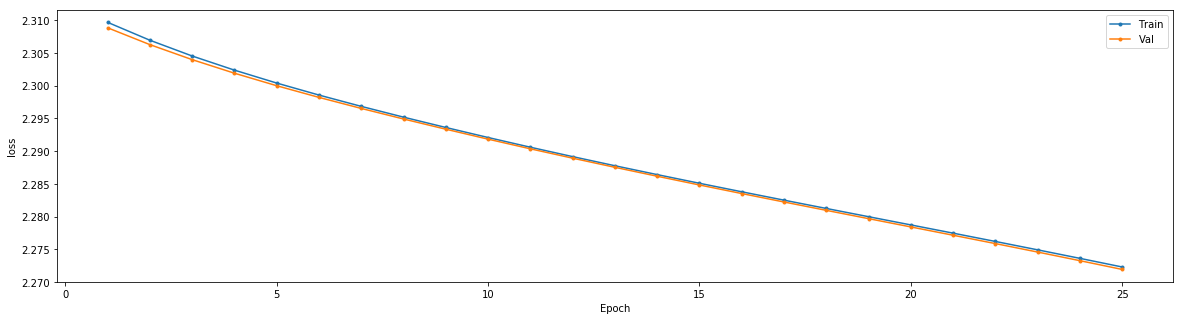

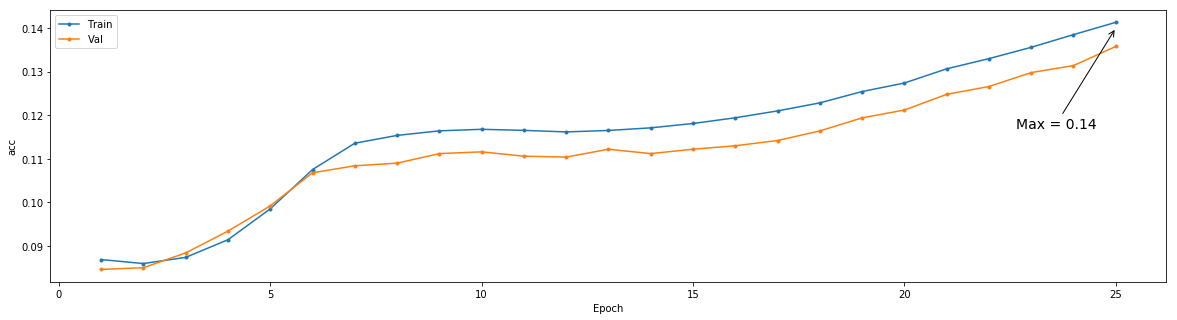

RMSProp


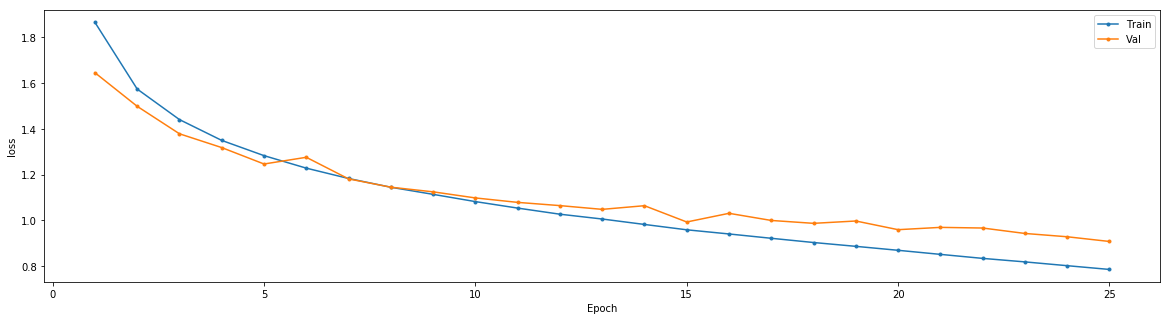

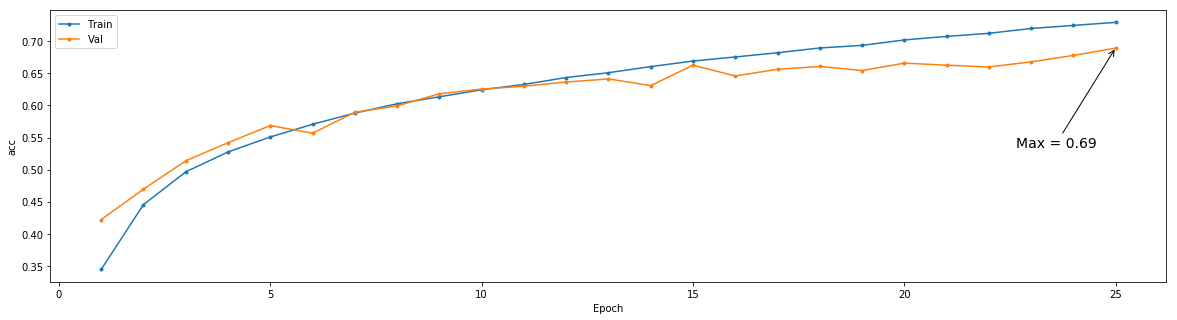

In [10]:
print("SDG")
chart_metric(history_d_sdg, "loss", 25)
chart_metric(history_d_sdg, "acc", 25)
print("RMSProp")
chart_metric(history_d_rmsprop, "loss", 25)
chart_metric(history_d_rmsprop, "acc", 25)

Al ver los gráficos después de entrenar con 25 epochs, se corrobora que el entrenamiento con SGD es más lento y que un algoritmo adaptivo como RMSProp mejora la rapidez de convergencia en el entrenamiento. En particular con 25 epochs en ambos casos se ve que van aprendiendo ya que la función de perdida decrementa, pero en RMSProp, en cada iteración lo decrementa más, mientras que en SGD es lineal.

Al ver la comparación del accuracy, la versión con SGD obtiene 0.16 como valor máximo a la epoch número 25, mientras que la versión con RMSProp obtiene 0.68 de acurracy en la misma cantidad de epochs.

## e)
Ahora bien, para mejorar los resultados encontrados deberá aumentar o reducir el número de capas, dependiendo de qué dice su intuición. Deberá elegir sobre dónde aumentar o reducir el número de capas, la fase convolucional y/o la fase *feed forward*, no olvide que al aumentar el número de capas (como en la sección 2) conlleva ciertas consecuencias, lo más importante el *overfitting*, vea cómo reducir ésto.


In [50]:
def get_ann_e_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # Se añade una nueva capa de convolución cn 64 filtros.
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model

model_e = get_ann_e_model()
model_e.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_e = model_e.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

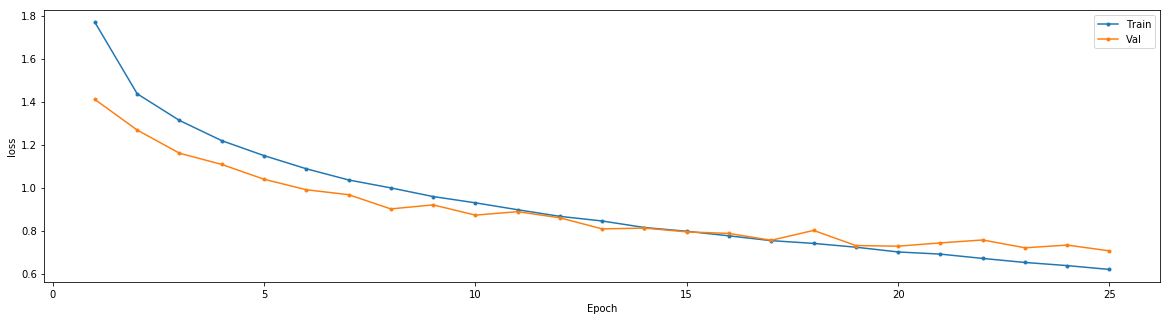

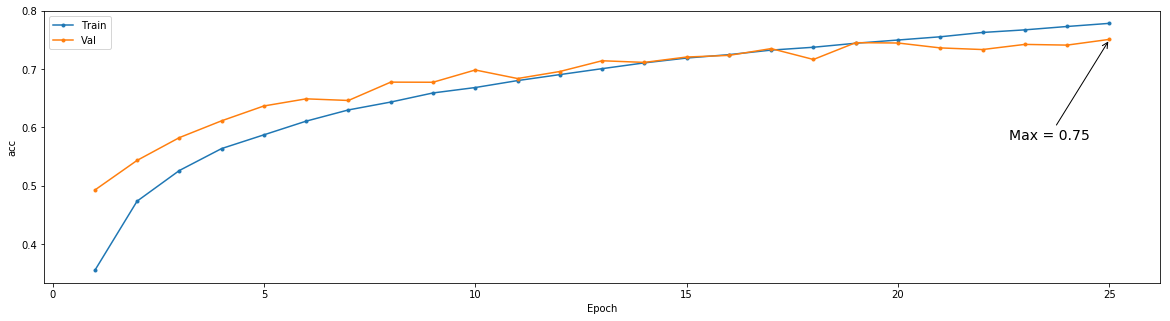

In [51]:
chart_metric(history_e, "loss", 25)
chart_metric(history_e, "acc", 25)

Se añade 1 nueva capa convolucional y una capa densa. Para mitigar el overfittin se decide ocupar ambos métodos de regularización *Batch normalization* y *Dropout* siguiendo las recomendaciones del articulo *"Don’t Use Dropout in Convolutional Networks."* [[1]](#ref). Efectivamente se mejora el resultado obtenido ya que se mejora el accuracy de 0,68 a 0,76.

## f)
Duplique el tamaño de los filtros utilizados en la primera capa convolucional. ¿Qué efecto tiene esto sobre el tipo de patrones que detectará la red? ¿Porqué usar filtros pequeños no impide detectar patrones más grandes?

In [57]:
def get_ann_f_model():
    model = Sequential()
    model.add(Conv2D(32, (3 * 3, 3 * 3), padding='same', input_shape=Xnorm_train.shape[1:],activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, (3 * 3, 3 * 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    return model

model_f = get_ann_f_model()
model_f.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_f = model_f.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

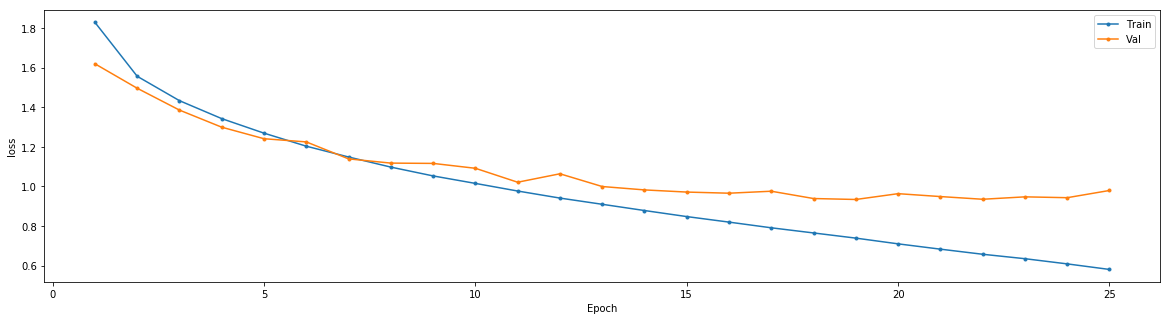

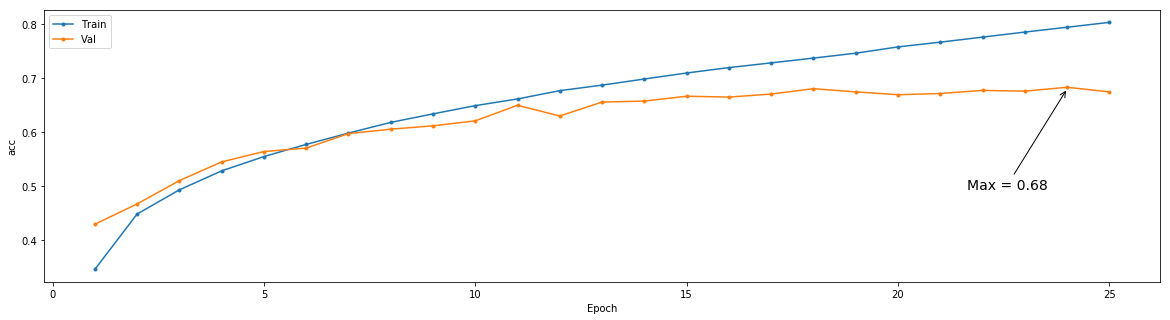

In [58]:
chart_metric(history_f, "loss", 25)
chart_metric(history_f, "acc", 25)

Al aumentar el tamaño del campo receptivo de la capa convolucional ocurre que se empezaran a detectar patrones más generales ya que se hara convolución sobre un área más grande de la imagen provocando que las caracteristicas que aprenda la red no sean tan especificas como las de una red con un tamaño más pequeño. Se cree que no afecta ya que filtros de la misma capa pueden detectar distintas caracteristicas y estos al ser combinados en una capa posterior pueden aproximar el mismo patrón superior.

## g)
Duplique el número de filtros utilizados en las capas convolucionales. ¿Qué efecto tiene esto sobre la capacidad de aprendizaje de la red?

In [62]:
def get_ann_f_model():
    model = Sequential()
    model.add(Conv2D(32 * 2, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64 * 2, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    return model

model_g = get_ann_f_model()
model_g.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_g = model_g.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

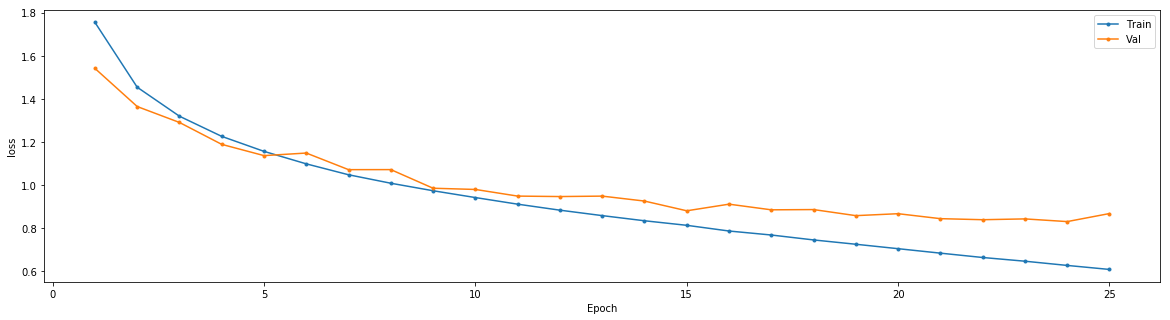

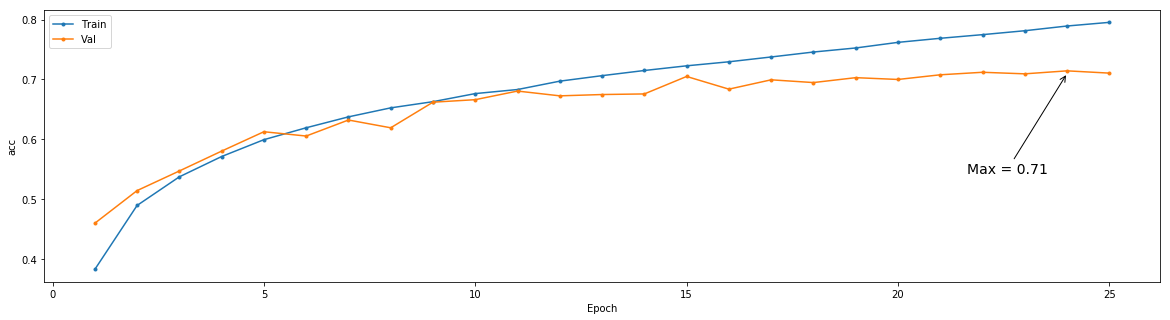

In [63]:
chart_metric(history_g, "loss", 25)
chart_metric(history_g, "acc", 25)

Al aumentar la cantidad de filtros se esperaria que la red pudiera aprender más caracteristicas a reconocer, por lo tanto debiese aumentar su poder de predicción/clasificación. Al ver los resultados obtenidos, efectivamente éste mejora, llegando a conseguir un accuracy del 0,71.

## h)
Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times P \times C \times P \times F \times F$ versus  $C \times C \times P \times C \times C \times P \times F \times F$. Use 32 filtros para la primera capa convolucional y 64 para la segunda.  Como resultado final de esta actividad, al igual que las otras, grafique los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).
> **Hint:** con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test), pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador ¿Dónde? ¿Qué tan potente?

In [11]:
def get_ann_h_1_model():
    model = Sequential()
    
    # C
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    
    # F
    model.add(Dropout(0.25))
    model.add(Dense(512,activation='relu'))
    
    # F
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))
    
    return model

def get_ann_h_2_model():
    model = Sequential()
    
    # C
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # C
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    # P
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    
    # F
    model.add(Dropout(0.25))
    model.add(Dense(512,activation='relu'))
    
    # F
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))
    
    return model

In [12]:
model_h_1 = get_ann_h_1_model()
model_h_1.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_h_1 = model_h_1.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model_h_2 = get_ann_h_2_model()
model_h_2.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_h_2 = model_h_2.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

Arquitectura normal


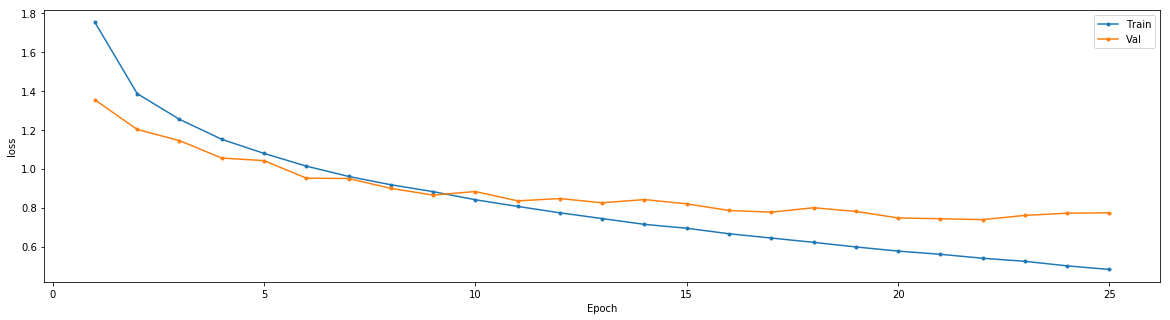

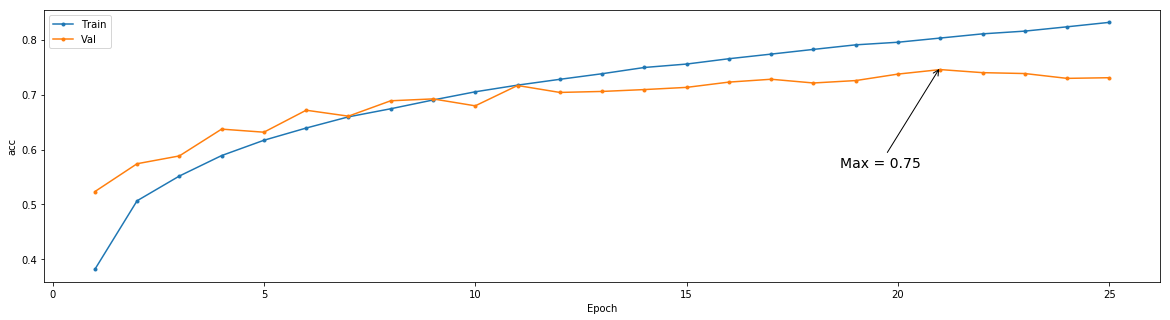

Arquitectura profunda


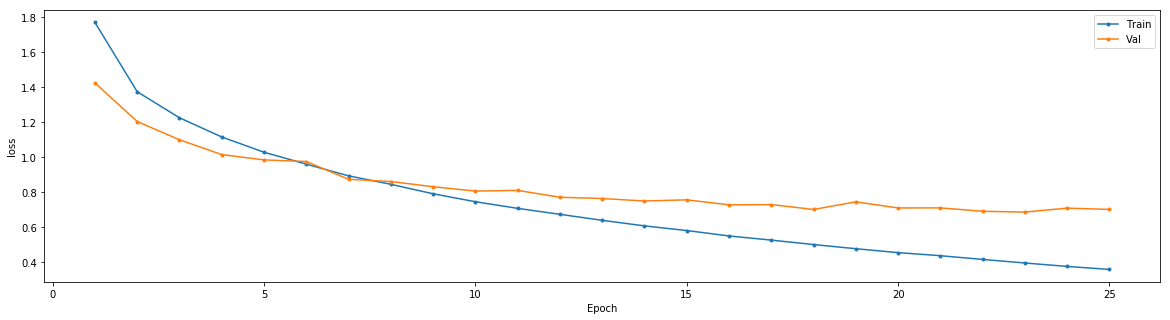

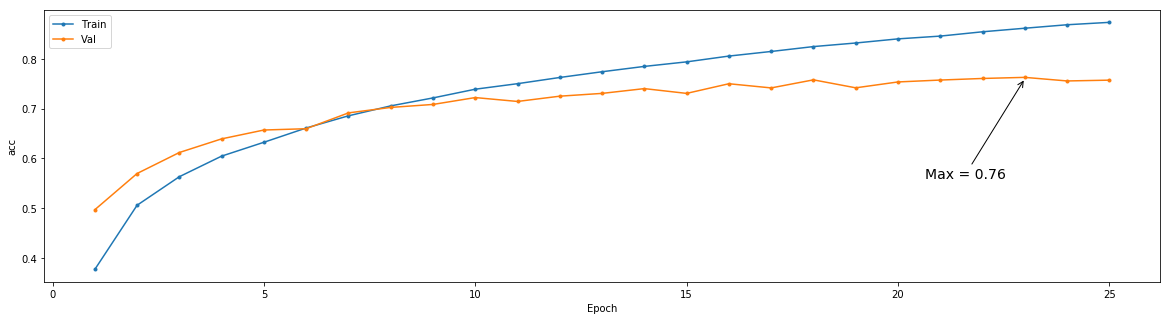

In [14]:
print("Arquitectura normal")
chart_metric(history_h_1, "loss", 25)
chart_metric(history_h_1, "acc", 25)

print("Arquitectura profunda")
chart_metric(history_h_2, "loss", 25)
chart_metric(history_h_2, "acc", 25)

Al ver los gráficos, efectivamente se obtienen modelos con un accuracy superior al 70%. El modelo más profundo tiene un mejor resultado, dando como máximo 0,78 de accuracy (en validación), esto se debe a que tiene más capas detectanto caracteristicas (capas de convolución), entonces se espera que tenga mayor poder de predicción.

Cabe destacar que ambos modelos eran sumamente susceptibles a over-fittin (comente las lineas de batch nomalization y dropout para ver el over-fitting), entonces por eso se decidió ocupar ambos regularizadores, aunque esto amotiguo el over-fitting pero no lo elimina, ya que se ve una clara tendencia a que el accuracy de validación se estanque, mientras que el de entrenamiento sigue subiendo.

La elección de donde poner las capas de batch normalization y dropout se deben a las recomendaciones del artículo *"Don’t Use Dropout in Convolutional Networks."* [[1]](#ref)

## i)
Algunos investigadores, han propuesto que las capas de *pooling* se pueden reemplazar por capas convoluciones con *stride* 2. ¿Se reduce dimensionalidad de este modo? Compruébelo verificando los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un *forward-pass*. Entrene la red resultante con el método que prefiera, gráficando los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [13]:
def get_ann_i_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=Xnorm_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Conv2D(32, (3, 3), strides=2, padding='same', activation='linear'))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Conv2D(64, (3, 3), strides=2, padding='same', activation='linear'))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))
    
    return model

model_i = get_ann_i_model()
model_i.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)        0         
__________

Al ver la salida del código anterior se aprecia que al aplicar las capas convolucionales con strides = 2, se reduce la dimensionalidad del input.

In [14]:
model_i.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_i = model_i.fit(Xnorm_train, y_train, epochs=25, batch_size=150, verbose=0, validation_data=(Xnorm_val,y_val))

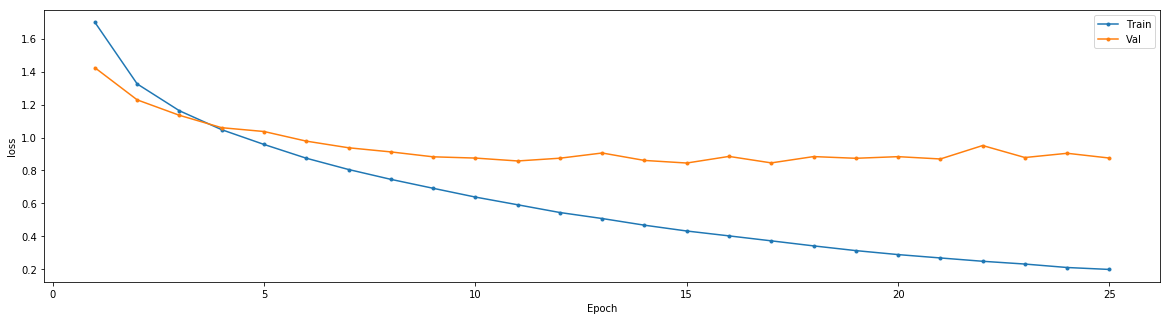

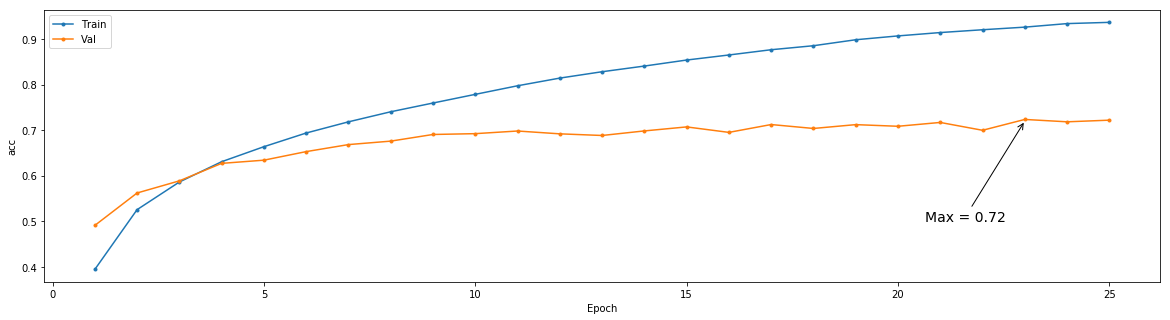

In [18]:
chart_metric(history_i, "loss", 25)
chart_metric(history_i, "acc", 25)

Una red comparable a la propuesta en esta pregunta es la primera arquitectura propuesta en la pregunta **h)** se aprecia que su única diferencia es que en vez de capas de pooling se ocupa convolucionales con strides. 

Al comparar el rendimineto de ambas arquitecturas se aprecia que la arquitectura de la pregunta **h)** da mejores resultados y que la red sin pooling tiene un *over-fitting* aun más pronunciado (el accuracy de entrenamiento llega al 0,9). Esto se debe que al cambiar la capa de pooling por una convolucional se añaden más parámetros, entonces la red opta por un modelo más complejo y pierde poder de generalización.

## j)
Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique por qué este procedimiento podrı́a ayudar a mejorar el modelo y el por qué las etiquetas no cambian al aplicar estas operaciones. Evalúe experimentalmente la conveniencia de incorporarlo.

In [26]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(Xnorm_train)

In [32]:
model_j = get_ann_b_model()
model_j.compile(optimizer = rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['acc'])
history_j = model_j.fit_generator(datagen.flow(Xnorm_train, y_train, batch_size=2), steps_per_epoch=1000, epochs=25, verbose=1, validation_data=(Xnorm_val, y_val))

Epoch 1/25
1000/1000 [==============================] - 22s 22ms/step - loss: 2.0980 - acc: 0.2205 - val_loss: 1.9714 - val_acc: 0.2830
Epoch 2/25
1000/1000 [==============================] - 23s 23ms/step - loss: 1.8741 - acc: 0.3260 - val_loss: 1.7213 - val_acc: 0.3780
Epoch 3/25
1000/1000 [==============================] - 23s 23ms/step - loss: 1.7863 - acc: 0.3565 - val_loss: 1.6368 - val_acc: 0.3980
Epoch 4/25
1000/1000 [==============================] - 21s 21ms/step - loss: 1.6800 - acc: 0.3860 - val_loss: 1.6520 - val_acc: 0.4032
Epoch 5/25
1000/1000 [==============================] - 22s 22ms/step - loss: 1.6681 - acc: 0.4020 - val_loss: 1.5928 - val_acc: 0.4158
Epoch 6/25
1000/1000 [==============================] - 22s 22ms/step - loss: 1.6450 - acc: 0.4050 - val_loss: 1.6425 - val_acc: 0.3754
Epoch 7/25
1000/1000 [==============================] - 22s 22ms/step - loss: 1.5571 - acc: 0.4610 - val_loss: 1.4515 - val_acc: 0.4612
Epoch 8/25
1000/1000 [==========================

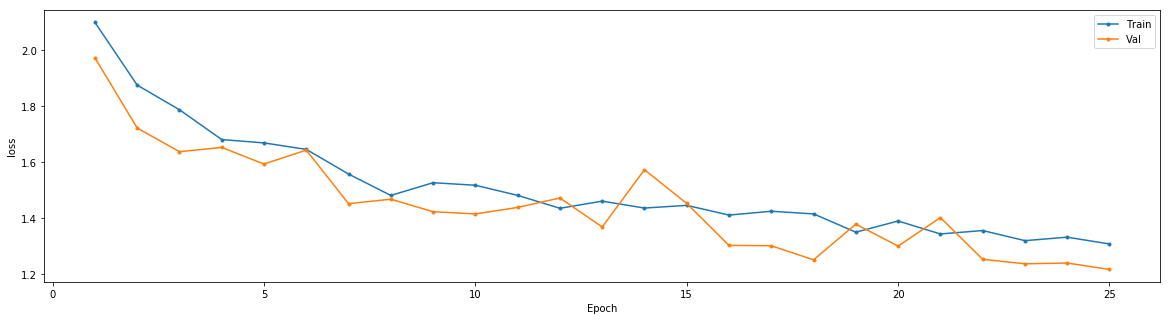

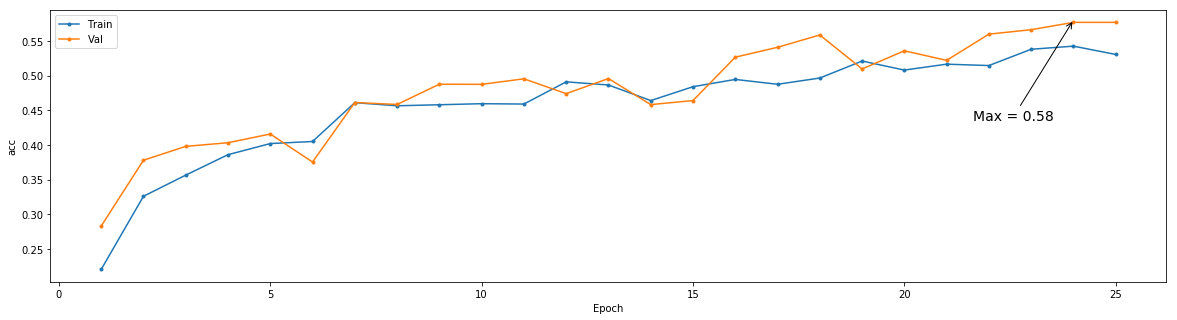

In [33]:
chart_metric(history_j, "loss", 25)
chart_metric(history_j, "acc", 25)

Esto ayuda ya que se añaden más ejemplo de distintas condiciones en las cuales pueden aparecer las clases a aprender. Las transformaciones no cambian las etiquetas finales porque si la imagen es rotada, reflejada o movida no cambia el hecho de la clase de lo que se ve en la imagen (un perrito rotado, sigue siendo un perro).

La técnica computacionalmente hablando es sumamente costosa, es por ello que se utilizaron valores muy pequeños para entrenar (batch_size=2 y steps_per_epoch=1000). Aún con valores pequeños al ver el gráfico del accuracy se aprecia que el valor de validación no se estanca, cosa que pasaba con la mayoria de las redes a lo largo de la experiencia (y en la red original de la pregunta **c)** 

## k)
Ahora se experimentará con el concepto de *transfer learning* [[11]](#refs), el cual consta en transferir conocimiento de un dominio fuente (*source domain*) a un dominio objetivo (*target domain*). En redes neuronales existen muchas representaciones de esto, en común consta en pre inicializar los pesos de la red de alguna manera que no sea con distribuciones de manera aleatoria, conocido como *fine tunning*. También está lo que es utilizar una representación generada a través de otra red entrenada con muchos datos, esto es tomar la red y "congelar" sus primeras capas para tomar esta representación y no entrenar esos pesos. Para ésto se utilizará VGG16 [[12]](#refs), una red entrenada con millones de imágenes y proporcionada a través de la interfaz de *keras*. Visualice el modelo y sus 23 capas.  Para esta instancia se utilizará todo lo aprendido por las capas convolucionales, es decir, se eliminan las capas densas del modelo y se agregan unas nuevas a ser entrenadas desde cero.  
*Recuerde normalizar los datos de la manera en que fue entrenado VGG* ¿Cuál es éste proceso?

**Respuesta:** *"The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel"*

In [16]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

X_train_vgg = preprocess_input(x_train.astype('float32'))
X_val_vgg = preprocess_input(x_val.astype('float32'))
X_test_vgg = preprocess_input(x_test.astype('float32'))

input_tensor=Input(shape=X_train_vgg.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor ) # LOAD PRETRAINED MODEL 

features_train = modelVGG.predict(X_train_vgg)
features_val = modelVGG.predict(X_val_vgg)
features_test = modelVGG.predict(X_test_vgg)

modelVGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

## l)
Entrene esta red agregando una capa densa de 512 neuronas seguido de un dropout de 0.5, finalmente es necesario agregar la capa de clasificación para las 10 clases. Utilice la misma configuración del optimizador para que las comparaciones sean válidas. Entrene unicamente por 15 *epochs* y grafique las curvas de entrenamiento con respecto al modelo definido en c) y la mejor encontrada ¿Qué sucede? Comente.

In [17]:
def get_ann_l_model():
    model = Sequential()
    model.add(Flatten(input_shape=features_train.shape[1:]))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_ann_l_model()
history_l = model.fit(features_train, y_train, epochs=25, batch_size=128, verbose=1, validation_data=(features_test,y_test))

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 5s 107us/step - loss: 8.0624 - acc: 0.3308 - val_loss: 4.4034 - val_acc: 0.5539
Epoch 2/25
45000/45000 [==============================] - 3s 71us/step - loss: 5.4357 - acc: 0.4912 - val_loss: 3.6841 - val_acc: 0.5912
Epoch 3/25
45000/45000 [==============================] - 3s 72us/step - loss: 4.4387 - acc: 0.5261 - val_loss: 2.9583 - val_acc: 0.6105
Epoch 4/25
45000/45000 [==============================] - 3s 68us/step - loss: 3.5118 - acc: 0.5394 - val_loss: 2.1996 - val_acc: 0.6120
Epoch 5/25
45000/45000 [==============================] - 3s 69us/step - loss: 2.5718 - acc: 0.5470 - val_loss: 1.6482 - val_acc: 0.6129
Epoch 6/25
45000/45000 [==============================] - 3s 69us/step - loss: 1.9364 - acc: 0.5481 - val_loss: 1.3857 - val_acc: 0.6107
Epoch 7/25
45000/45000 [==============================] - 4s 82us/step - loss: 1.6149 - acc: 0.5615 - val_loss: 1.2852 - val_ac

Arquitectura pregunta c


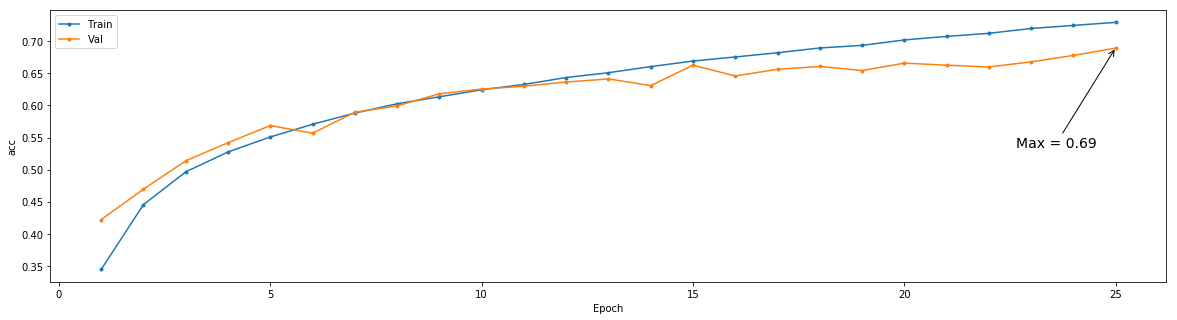

Arquitectura transfer learning


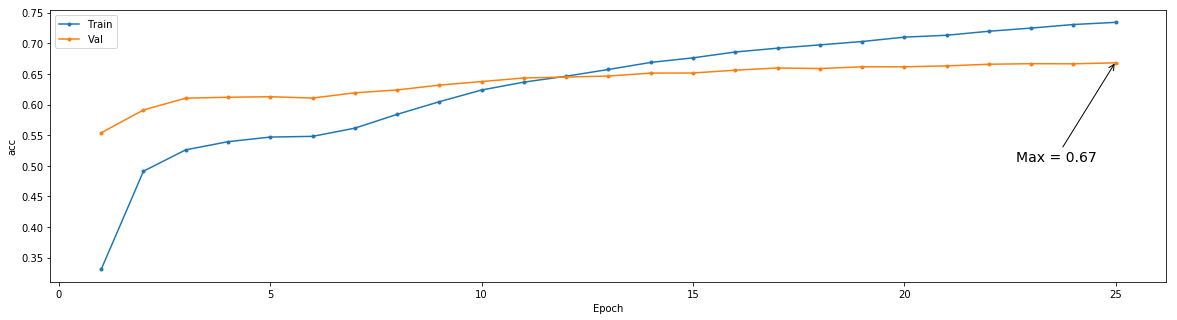

Mejor arquitectura hasta el momento ( pregunta h_2 )


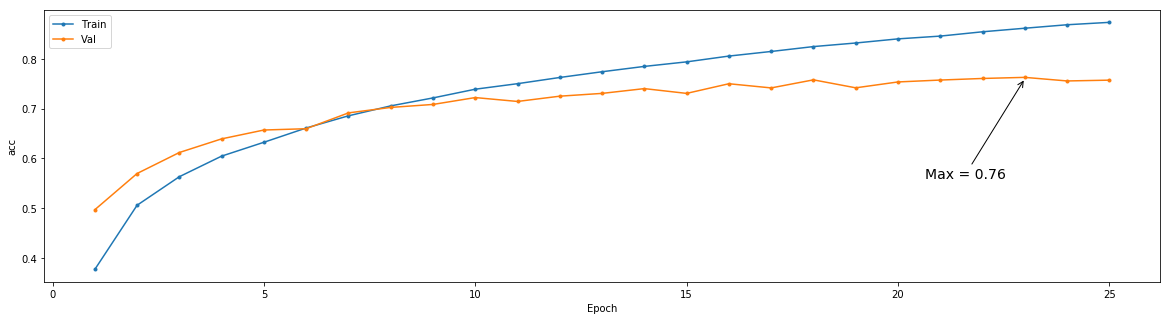

In [19]:
print("Arquitectura pregunta c")
chart_metric(history_d_rmsprop, "acc", 25)
print("Arquitectura transfer learning")
chart_metric(history_l, "acc", 25)
print("Mejor arquitectura hasta el momento ( pregunta h_2 )")
chart_metric(history_h_2, "acc", 25)

La nueva red no es capaz de superar a la arquitectura original definida en **c)** o a la mejor mejor hasta el momento **h-2)**. Se observa que desde la epoch 15 en adelante el accuracy de validación se estanca, pues la red empieza a sufrir de sobre ajuste. Efecto que se mitiga en la arquitectura de la pregunta **h-2)** mediante el uso de capaz regularizadoras como *batch normalization* y *dropout*.

## m) 
Agregue una capa de normalización (*Batch Normalization* [[9]](#refs)) de las activaciones en las capas densas, esto es, restar por la media del *mini-batch* y dividir por la desviación estándar en conjunto con unos parámetros aprendibles, además de agregar *Dropout*[[8]](#refs). Vuelva a entrenar el modelo con la misma configuración. Comente lo observado y compare las curvas de convergencia con los modelos anteriores ¿Por qué esto mejora a lo presentado en l)? ¿Qué beneficio tiene resolver un problema con una red pre-entrenada?

In [53]:
def get_ann_m_model():
    model = Sequential()
    model.add(Flatten(input_shape=features_train.shape[1:]))
    
    model.add(BatchNormalization())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=rmsprop(lr=1e-4, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = get_ann_m_model()
history_m = model.fit(features_train, y_train, epochs=25, batch_size=128, verbose=1, validation_data=(features_test,y_test))

Train on 45000 samples, validate on 10000 samples
Epoch 1/25
45000/45000 [==============================] - 3s 77us/step - loss: 2.0032 - acc: 0.4061 - val_loss: 1.2639 - val_acc: 0.5894
Epoch 2/25
45000/45000 [==============================] - 5s 110us/step - loss: 1.4977 - acc: 0.5340 - val_loss: 1.1401 - val_acc: 0.6246
Epoch 3/25
45000/45000 [==============================] - 5s 120us/step - loss: 1.3473 - acc: 0.5695 - val_loss: 1.0838 - val_acc: 0.6428
Epoch 4/25
45000/45000 [==============================] - 6s 126us/step - loss: 1.2522 - acc: 0.5923 - val_loss: 1.0466 - val_acc: 0.6522
Epoch 5/25
45000/45000 [==============================] - 6s 124us/step - loss: 1.1914 - acc: 0.6078 - val_loss: 1.0236 - val_acc: 0.6595
Epoch 6/25
45000/45000 [==============================] - 6s 123us/step - loss: 1.1377 - acc: 0.6200 - val_loss: 1.0042 - val_acc: 0.6672
Epoch 7/25
45000/45000 [==============================] - 6s 134us/step - loss: 1.0949 - acc: 0.6283 - val_loss: 0.9931 - v

Arquitectura transfer learning, mejorada


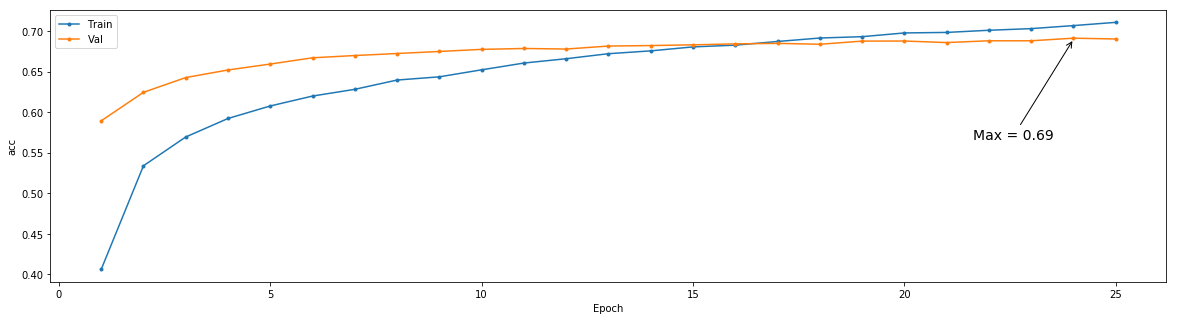

In [56]:
print("Arquitectura transfer learning, mejorada")
chart_metric(history_m, "acc", 25)

Al comparar los resultados efectivamente se mejora el resutado obtenido anteriormente, esto se debe a que el uso de estas capas tienen efectos regularizadores. A continuación se explica porque es que cada una de las técnicas ayuda.

- DropOut: Durate el entrenamiento en un forward pass y un backward pass se ignoran ciertas neuronas con cierta probabilidad p. Esto se hace para que así las neuronas de la misma capa intenten suplir un poco lo que estaban aprendiendo las neuronas vecinas (de la misma capa). El resultado esperado es que no se produzca sobre ajuste y se aprenda un modelo más general.
- Batch Normalization, lo que hace este método es tomar los input y normalizarlos (media 0 y desviación estandar 1), esto hace que valores que le llegan a las neuronas futuras no sean muy grandes o muy pequeños haciendo posible ocupar tasas de aprendizaje más grandes y provee un efecto regularizador [[2]](#refs). En particular para ReLu evita el efecto de explosión de gradientes, además también vuelve mas independiente a la red de la inicialización de los pesos.[[3]](#ref)

El principal beneficio de resolver un problema con una red pre-entrenada es que se ahorra tiempo ya que no hay que plantear una arquitectura y entrenarla ya que se puede llegar y utilizar.

## n) 
Genere $T$ nuevas etiquetas para el dataset de CIFAR en base a las etiquetas de éstas, pero que sean "paralelas", es decir, un objeto/imagen puede tener una etiqueta de las posibles en CIFAR y una de las nuevas que usted genere, ésto se denomina **Multi-task**[[13]](#refs). Por ejemplo una nueva *task* podría ser identificar/distinguir entre animales u objetos (de manera binaria, 0 y 1) en los datos de CIFAR, ésto debe ser unicamente extraído a través de las etiquetas de CIFAR. Defina la sección compartida de la red, que se compartirá para aprender las $T+1$ tareas, que tome como entrada las imágenes de CIFAR, ya sean los pixeles o la representación de *VGG* y genere como salida una representación intermedia (*hidden*) que servirá después para aprender la probabilidad (*softmax* o *sigmoid*) de cada *task*.

In [108]:
# ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def is_it_alive(y_values):
    matrix = np.zeros((y_values.shape[0], 1))
    n = matrix.shape[0]
    for i in range(n):
        current_class = np.argmax(y_values[i])
    if current_class in [2, 3, 4, 5, 6, 7]:
        matrix[i][0] = 1
    else:
        matrix[i][0] = 0
    return matrix

def tipe_of_movement(y_values):
    matrix = np.zeros((y_values.shape[0], 3))
    n = matrix.shape[0]
    for i in range(n):
        current_class = np.argmax(y_values[i])
    if current_class in [1, 3, 4, 5, 7, 9]: 
        matrix[i][0] = 1
    elif current_class in [0, 2]:
        matrix[i][0] = 1
    else:
        matrix[i][1] = 1
    return matrix

# aereo -> [0, 2]
# marino -> [8, 6]
# terrestre -> [1, 3, 4, 5, 7, 9]

y_train2 = is_it_alive(y_train)
y_val2 = is_it_alive(y_val)

y_train3 = tipe_of_movement(y_train)
y_val3 = tipe_of_movement(y_val)

Se generan 2 nuevas task, una para detectar si es que lo que se ve está vivo o no (se asume que las fotos de animales son animales vivos) y otra que dice que tipo de movimiento presenta lo observado en la foto (aereo, marino, terrestre).

In [60]:
# Shared layers
shared_model = Sequential()

shared_model.add(Flatten(input_shape=features_train.shape[1:]))
shared_model.add(BatchNormalization())
shared_model.add(Dense(512, activation='relu'))
shared_model.add(BatchNormalization())
shared_model.add(Dropout(rate=0.5))

shared_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 512)               0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
Total params: 266,752
Trainable params: 264,704
Non-trainable params: 2,048
_________________________________________________________________


## o)
Defina y entrene el modelo multi-task que prediga las $T$ nuevas *task* que definió en la pregunta anterior más la clasificación sobre CIFAR, *task 1*. Grafique las $T+1$ funciones objetivos que se optimizan en paralelo, comente. Verifique si el uso de las nuevas $T$ *task* auxiliares ayudan a regularizar a la red sobre la tarea principal, la clasificación sobre las etiquetas de CIFAR (*task 1*).   
*Como ayuda se entrega que como la task1 es la clasificación de CIFAR la loss1 debiera ser 'categorical crossentropy'*

In [109]:
from keras.models import Model

input_tasks = Input(shape = features_train.shape[1:])
shared = shared_model(input_tasks)

class_cifar = Dense(10, activation='softmax', name='cifar')(shared)
task2 = Dense(1, activation='sigmoid', name='is_it_alive')(shared)
task3 = Dense(3, activation='softmax', name='movement')(shared)

multitask_model = Model(inputs=input_tasks, outputs = [class_cifar, task2, task3])
multitask_model.compile(loss = ['categorical_crossentropy', 'binary_crossentropy', 'categorical_crossentropy'], optimizer=rmsprop(lr=1e-4, decay=1e-6), metrics=['acc', 'binary_crossentropy', 'categorical_crossentropy'])
hist12 = multitask_model.fit(features_train, [y_train, y_train2, y_train3], epochs=25, batch_size=256, verbose=0, validation_data=(features_val, [y_val, y_val2, y_val3]))

In [98]:
for i in hist12.history:
    print(i)

val_loss
val_cifar_loss
val_is_it_alive_loss
val_cifar_acc
val_cifar_binary_crossentropy
val_cifar_categorical_crossentropy
val_is_it_alive_acc
val_is_it_alive_binary_crossentropy
val_is_it_alive_categorical_crossentropy
loss
cifar_loss
is_it_alive_loss
cifar_acc
cifar_binary_crossentropy
cifar_categorical_crossentropy
is_it_alive_acc
is_it_alive_binary_crossentropy
is_it_alive_categorical_crossentropy


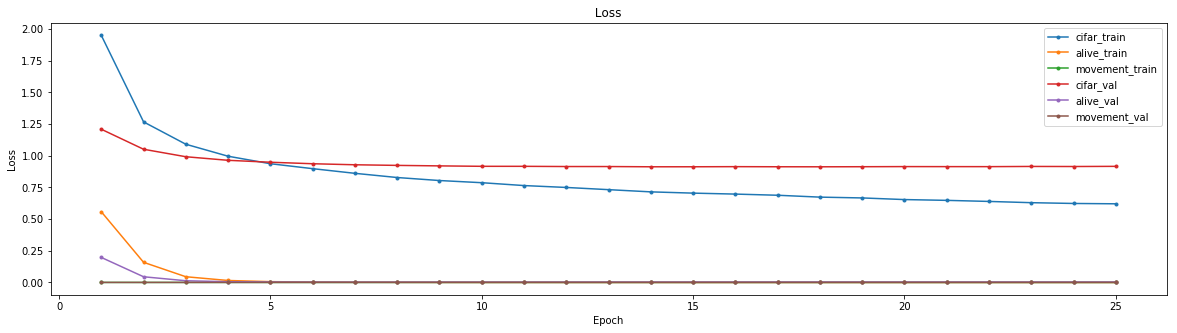

In [110]:
# Voy a graficar las funciones objetivos a minimizar

epoch_arr = [i+1 for i in range(25)]
plt.figure(figsize = (20,5))

train_loss_keys = ['cifar_categorical_crossentropy', 'is_it_alive_binary_crossentropy', 'movement_categorical_crossentropy']
for i in train_loss_keys:
    plt.plot(epoch_arr, hist12.history[i], '.-')
    
val_loss_keys = ['val_cifar_categorical_crossentropy', 'val_is_it_alive_binary_crossentropy', 'val_movement_categorical_crossentropy']
for i in val_loss_keys:
    plt.plot(epoch_arr, hist12.history[i], '.-')
    

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend( ('cifar_train', 'alive_train', 'movement_train', 'cifar_val', 'alive_val', 'movement_val') )
plt.title(' Loss ')

plt.show()

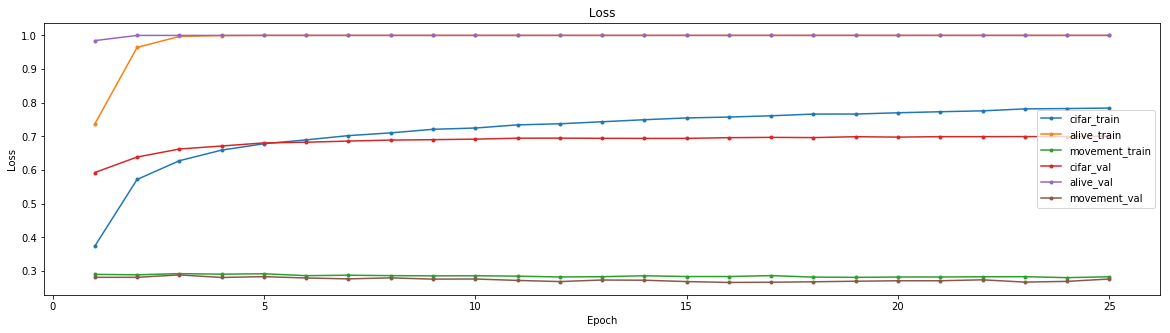

In [111]:
# Voy a graficar las accuracy

epoch_arr = [i+1 for i in range(25)]
plt.figure(figsize = (20,5))

train_loss_keys = ['cifar_acc', 'is_it_alive_acc', 'movement_acc']
for i in train_loss_keys:
    plt.plot(epoch_arr, hist12.history[i], '.-')
    
val_loss_keys = ['val_cifar_acc', 'val_is_it_alive_acc', 'val_movement_acc']
for i in val_loss_keys:
    plt.plot(epoch_arr, hist12.history[i], '.-')
    

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend( ('cifar_train', 'alive_train', 'movement_train', 'cifar_val', 'alive_val', 'movement_val') )
plt.title(' Loss ')

plt.show()

Al ver los resultados no se aprecia algun efecto regularizador ya que la diferencia entre los valores de entrenamiento y validación para cifar son notorios. La validación se va quedando estancada mientras que el entrenamiento sigue subiendo (accuracy)

## p)
Elija una de las redes entrenadas en esta sección (preferentemente una con buen desempeño) y determine las predicciones menos insegura de la red, en base a algún criterio (por ejemplo la predicciones con mayor entropía en su probabilidad), también ver en qué etiquetas se tiende a confundir, por ejemplo la red podría a tender a confundir camiones con autos. Conjeture el motivo de tal confusión. *Para esto último se puede generar una __[matriz de confusión](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)__*

In [11]:
y_pred = model_h_2.predict_classes(Xnorm_test)
y_true = y_test.argmax(axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
metric = classification_report(y_true, y_pred, target_names=label_names)
conf = pd.DataFrame(conf_matrix, index=label_names, columns=label_names)

In [29]:
print(metric)
display(conf)

              precision    recall  f1-score   support

    airplane       0.84      0.72      0.77      1000
  automobile       0.84      0.89      0.87      1000
        bird       0.77      0.56      0.65      1000
         cat       0.50      0.66      0.57      1000
        deer       0.74      0.67      0.70      1000
         dog       0.63      0.70      0.67      1000
        frog       0.92      0.70      0.79      1000
       horse       0.74      0.85      0.79      1000
        ship       0.78      0.90      0.84      1000
       truck       0.85      0.81      0.83      1000

   micro avg       0.75      0.75      0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,718,23,21,38,12,11,2,16,114,45
automobile,5,887,5,11,2,4,1,2,39,44
bird,55,6,555,125,80,89,22,47,16,5
cat,9,9,38,663,42,159,17,39,14,10
deer,12,4,40,97,672,43,15,100,12,5
dog,7,4,12,182,28,702,4,52,6,3
frog,2,9,35,145,40,42,701,11,10,5
horse,7,6,6,35,30,54,0,849,7,6
ship,26,21,4,19,3,4,2,4,901,16
truck,15,81,4,22,2,3,2,22,37,812


La etiqueta de nave es la predicción más segura, ya que al ver el recall nos dice que el 90% de todas las naves es detectado.

Al ver la matriz de confusión se puede observa que hay clases que tienden a confundirse más, por ejemplo 

- Perros con gatos
- Ranas con gatos
- Benado con caballo
- Ave con gato

Esto se debe a que las clases deben tener varias sub caracteristicas en común, por ejemplo los perros y gatos en general coinciden en tener 4 patas, orejas, además el contorno de un gato no es tán distinto si lo comparamos con otras clases como un camión.

## q)
Elija una de las redes entrenadas (preferentemente una con buen desempeño) y visualice los pesos correspondientes a los filtros de la primera capa convolucional. Visualice además el efecto del filtro sobre algunas imágenes de entrenamiento (*forward pass*).

In [30]:
weights = model_h_2.get_weights()[0][:,:,0,:]

3

## Referencias
- [1] Don’t Use Dropout in Convolutional Networks.. (2018). Towards Data Science. Retrieved 3 May 2019, from https://towardsdatascience.com/dont-use-dropout-in-convolutional-networks-81486c823c16
- [2] Batch normalization in Neural Networks. (2017). Towards Data Science. Retrieved 1 May 2019, from https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
- [3] Batch Normalization. (2017). Towards Data Science. Retrieved 3 May 2019, from https://towardsdatascience.com/batch-normalization-8a2e585775c9


<hr style="height:2px;border:none"/>